In [1]:
import os
import numpy as np
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet152,ResNet50,VGG19,InceptionV3,MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [2]:
def load_images_from_folder(base_path,subpath):
    datasets = {'healthy': {'images': [], 'labels': []},
                'parkinson': {'images': [], 'labels': []}}
    
    for dataset in ['testing', 'training']:
        dataset_path = os.path.join(base_path, subpath, dataset)
        
        for class_label, class_folder in enumerate(['healthy', 'parkinson']):
            class_path = os.path.join(dataset_path, class_folder)
            
            if os.path.isdir(class_path):
                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    
                    try:
                        with Image.open(img_path) as img:
                            img = img.convert('RGB')
                            img = img.resize((224, 224))  # Adjust size as needed
                            img_array = np.array(img)
                            datasets[class_folder]['images'].append(img_array)
                            datasets[class_folder]['labels'].append(class_label)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    for dataset in datasets:
        datasets[dataset]['images'] = np.array(datasets[dataset]['images'])
        datasets[dataset]['labels'] = np.array(datasets[dataset]['labels'])
    
    return datasets


In [3]:
# Usage
base_path = 'D:\Projects\Parkinsons_disease\image_model_v2\data'
datasets_spiral = load_images_from_folder(base_path,'spiral')

# Access healthy and parkinson data separately
X_healthy_spiral, y_healthy_spiral = datasets_spiral['healthy']['images'], datasets_spiral['healthy']['labels']
X_parkinson_spiral, y_parkinson_spiral = datasets_spiral['parkinson']['images'], datasets_spiral['parkinson']['labels']

print(f"Loaded {len(X_healthy_spiral)} healthy images and {len(X_parkinson_spiral)} parkinson images of spiral")
print(f"Image shape: {X_healthy_spiral[0].shape}")
print(f"Number of classes: {len(np.unique(np.concatenate([y_healthy_spiral, y_parkinson_spiral])))}")

Loaded 51 healthy images and 51 parkinson images of spiral
Image shape: (224, 224, 3)
Number of classes: 2


In [4]:
X = np.concatenate([X_healthy_spiral,X_parkinson_spiral],axis=0)
y = np.concatenate([y_healthy_spiral,y_parkinson_spiral],axis=0)
print(f"{X.shape},{y.shape}")

(102, 224, 224, 3),(102,)


In [5]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=0)

In [6]:
print(f"train shape : {x_train.shape},{y_train.shape}")
print(f"val shape   : {x_val.shape},{y_val.shape}")
print(f"test shape  : {x_test.shape},{y_test.shape}")

train shape : (72, 224, 224, 3),(72,)
val shape   : (9, 224, 224, 3),(9,)
test shape  : (21, 224, 224, 3),(21,)


1


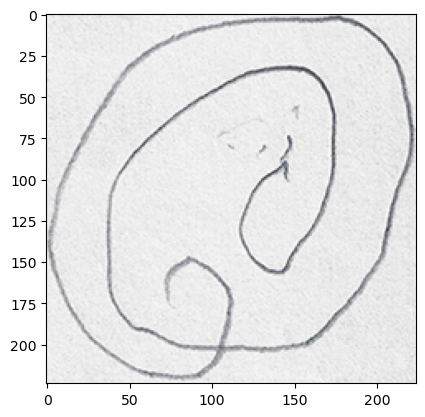

In [7]:
i =8
plt.imshow(x_train[i])
print(y_train[i])

# ResNet152

In [8]:
base_model = ResNet152(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet152_model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
    
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
resnet152_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = resnet152_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 29s 2s/step - loss: 0.7576 - accuracy: 0.5833 - val_loss: 0.5128 - val_accuracy: 0.7778
Epoch 2/100
6/6 [==============================] - 6s 990ms/step - loss: 0.4391 - accuracy: 0.8750 - val_loss: 0.4574 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 6s 1s/step - loss: 0.3858 - accuracy: 0.8194 - val_loss: 0.3396 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 6s 1s/step - loss: 0.3149 - accuracy: 0.9028 - val_loss: 0.2950 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 6s 1s/step - loss: 0.2806 - accuracy: 0.9028 - val_loss: 0.2691 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 6s 1s/step - loss: 0.2442 - accuracy: 0.9167 - val_loss: 0.2636 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 6s 963ms/step - loss: 0.2357 - accuracy: 0.9167 - val_loss: 0.2219 - val_accuracy: 0.8889
Epoch 8/100
6/6 [==========

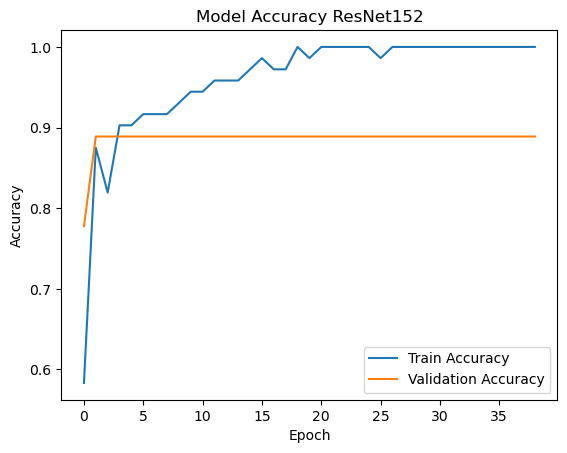

In [10]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy ResNet152')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

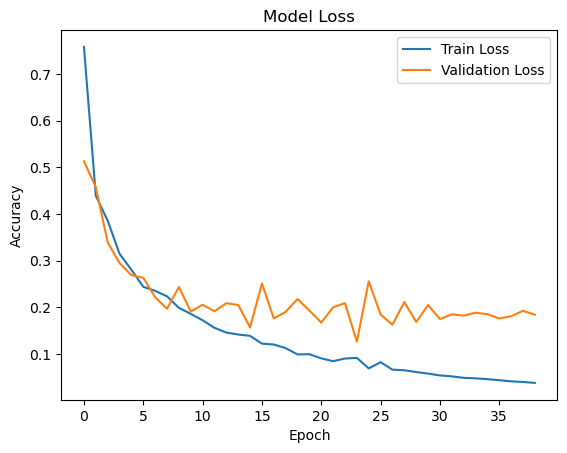

In [11]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ResNet50

In [40]:
base_model = ResNet50(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

resnet50_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [41]:
history = resnet50_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 8s 661ms/step - loss: 0.7621 - accuracy: 0.4444 - val_loss: 0.4187 - val_accuracy: 0.8889
Epoch 2/100
6/6 [==============================] - 2s 406ms/step - loss: 0.5319 - accuracy: 0.7500 - val_loss: 0.3705 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 2s 418ms/step - loss: 0.4437 - accuracy: 0.8056 - val_loss: 0.2730 - val_accuracy: 0.7778
Epoch 4/100
6/6 [==============================] - 2s 383ms/step - loss: 0.4146 - accuracy: 0.8194 - val_loss: 0.3179 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 3s 450ms/step - loss: 0.3632 - accuracy: 0.8472 - val_loss: 0.2603 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 2s 413ms/step - loss: 0.3449 - accuracy: 0.8472 - val_loss: 0.2484 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 2s 391ms/step - loss: 0.3069 - accuracy: 0.8472 - val_loss: 0.2848 - val_accuracy: 0.8889
Epoch 8/100
6

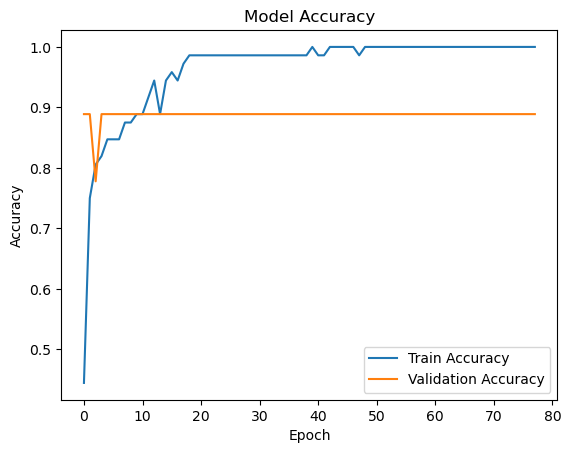

In [42]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

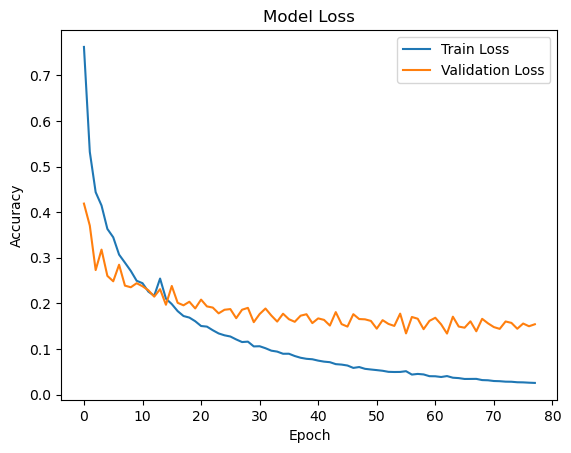

In [43]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# VGG19

In [16]:
base_model = VGG19(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

vgg_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [17]:
history = vgg_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 26s 3s/step - loss: 0.7616 - accuracy: 0.4583 - val_loss: 0.4268 - val_accuracy: 0.8889
Epoch 2/100
6/6 [==============================] - 5s 919ms/step - loss: 0.4883 - accuracy: 0.7361 - val_loss: 0.3249 - val_accuracy: 0.7778
Epoch 3/100
6/6 [==============================] - 5s 898ms/step - loss: 0.4028 - accuracy: 0.8472 - val_loss: 0.2401 - val_accuracy: 0.8889
Epoch 4/100
6/6 [==============================] - 5s 904ms/step - loss: 0.3374 - accuracy: 0.8889 - val_loss: 0.1905 - val_accuracy: 0.8889
Epoch 5/100
6/6 [==============================] - 5s 908ms/step - loss: 0.3060 - accuracy: 0.9028 - val_loss: 0.1820 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 5s 890ms/step - loss: 0.2566 - accuracy: 0.9167 - val_loss: 0.1892 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 5s 900ms/step - loss: 0.2404 - accuracy: 0.9167 - val_loss: 0.1611 - val_accuracy: 0.8889
Epoch 8/100
6/6

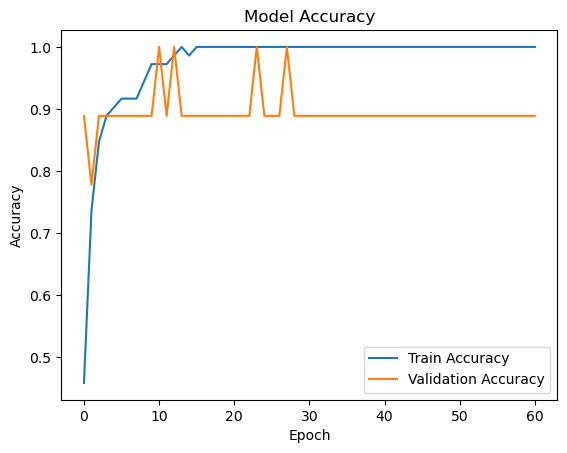

In [18]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

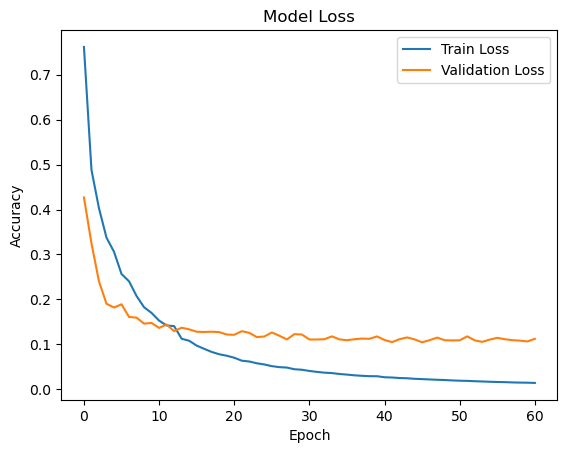

In [19]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# InceptionNet

In [20]:
base_model = InceptionV3(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

inception_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [21]:
history = inception_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 17s 2s/step - loss: 13.0972 - accuracy: 0.4444 - val_loss: 6.8897 - val_accuracy: 0.6667
Epoch 2/100
6/6 [==============================] - 2s 288ms/step - loss: 8.7098 - accuracy: 0.5139 - val_loss: 15.6448 - val_accuracy: 0.3333
Epoch 3/100
6/6 [==============================] - 2s 341ms/step - loss: 6.3747 - accuracy: 0.5694 - val_loss: 2.4389 - val_accuracy: 0.6667
Epoch 4/100
6/6 [==============================] - 2s 285ms/step - loss: 2.6202 - accuracy: 0.6111 - val_loss: 3.2321 - val_accuracy: 0.4444
Epoch 5/100
6/6 [==============================] - 2s 319ms/step - loss: 2.1505 - accuracy: 0.5833 - val_loss: 0.3538 - val_accuracy: 0.7778
Epoch 6/100
6/6 [==============================] - 2s 292ms/step - loss: 1.8074 - accuracy: 0.6250 - val_loss: 2.4542 - val_accuracy: 0.6667
Epoch 7/100
6/6 [==============================] - 2s 287ms/step - loss: 1.9705 - accuracy: 0.6250 - val_loss: 2.6400 - val_accuracy: 0.5556
Epoch 8/100
6

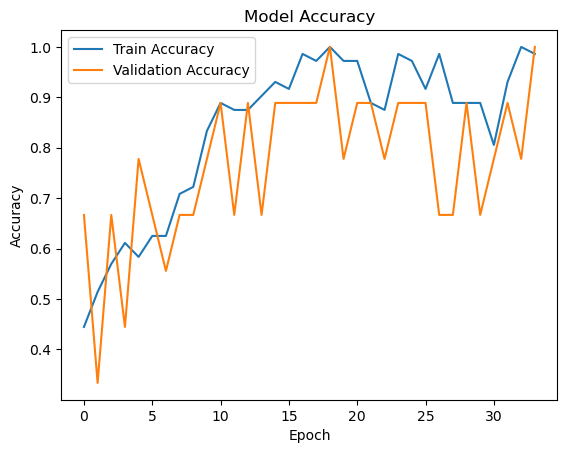

In [22]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

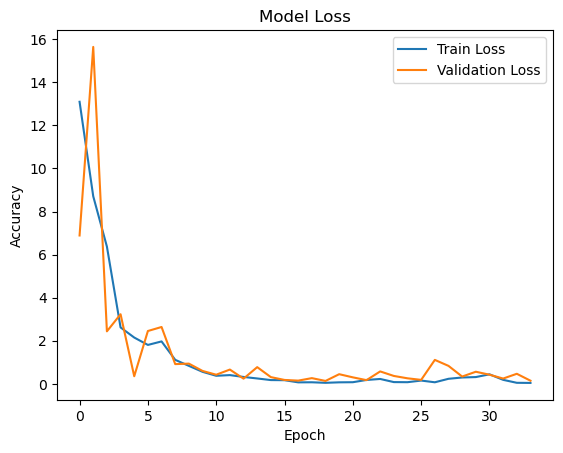

In [23]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# MobileNet V3

In [24]:
base_model = MobileNetV3Large(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce spatial dimensions
x = Dense(1024, activation='relu')(x)  # Dense layer for feature extraction
predictions = Dense(1, activation='sigmoid')(x)  # Output layer

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [25]:
history = mobilenet_model.fit(x_train,y_train,epochs=100,batch_size=12,validation_data=(x_val,y_val),callbacks=[early_stopping])

Epoch 1/100
6/6 [==============================] - 9s 664ms/step - loss: 0.7653 - accuracy: 0.4861 - val_loss: 0.5588 - val_accuracy: 0.7778
Epoch 2/100
6/6 [==============================] - 1s 124ms/step - loss: 0.6398 - accuracy: 0.5833 - val_loss: 0.4964 - val_accuracy: 0.8889
Epoch 3/100
6/6 [==============================] - 1s 118ms/step - loss: 0.5363 - accuracy: 0.7917 - val_loss: 0.4695 - val_accuracy: 0.7778
Epoch 4/100
6/6 [==============================] - 1s 125ms/step - loss: 0.4919 - accuracy: 0.8194 - val_loss: 0.4219 - val_accuracy: 0.7778
Epoch 5/100
6/6 [==============================] - 1s 128ms/step - loss: 0.4603 - accuracy: 0.8472 - val_loss: 0.3654 - val_accuracy: 0.8889
Epoch 6/100
6/6 [==============================] - 1s 122ms/step - loss: 0.4245 - accuracy: 0.8333 - val_loss: 0.3541 - val_accuracy: 0.8889
Epoch 7/100
6/6 [==============================] - 1s 123ms/step - loss: 0.4002 - accuracy: 0.8472 - val_loss: 0.3428 - val_accuracy: 0.8889
Epoch 8/100
6

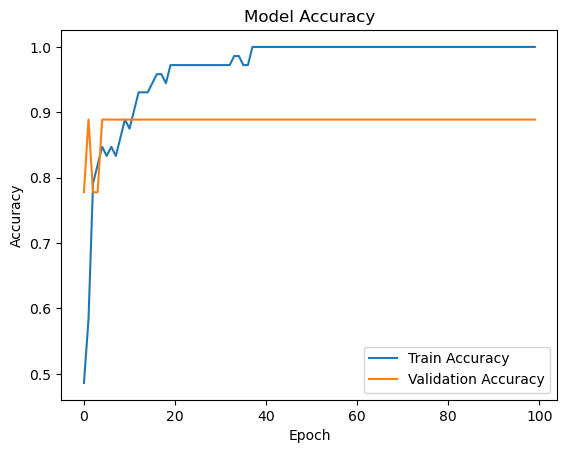

In [26]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

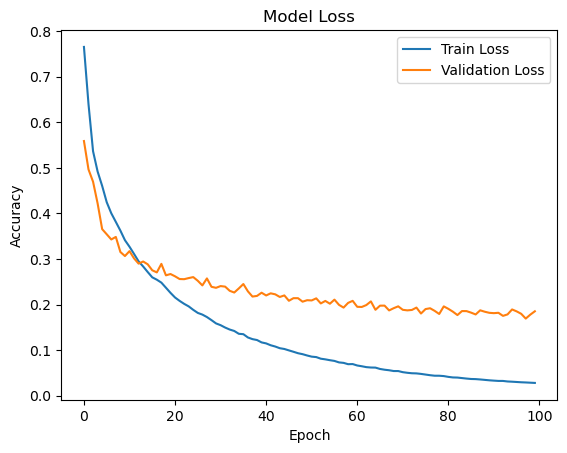

In [27]:
# Plot training & validation accuracy
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [44]:
ypreds_resnet50 = resnet50_model.predict(x_test)
ypreds_resnet152 = resnet152_model.predict(x_test)
ypreds_mobilenet = mobilenet_model.predict(x_test)
ypreds_inception = inception_model.predict(x_test)
ypreds_vgg19 = vgg_model.predict(x_test)
resnet50_model.save('/models/resnet50_spiral.keras')
resnet152_model.save('/models/resnet152_spiral.keras')
mobilenet_model.save('/models/mobilev3_spiral.keras')
inception_model.save('/models/inception_spiral.keras')
vgg_model.save('/models/vgg_spiral.keras')

In [45]:
ypreds_resnet50 = np.where(ypreds_resnet50>=0.5,1,0) 
ypreds_resnet152 = np.where(ypreds_resnet152>=0.5,1,0)
ypreds_mobilenet = np.where(ypreds_mobilenet>=0.5,1,0)
ypreds_inception = np.where(ypreds_inception>=0.5,1,0)
ypreds_vgg19 =np.where(ypreds_vgg19>=0.5,1,0)

# Metrics for Resnet50

In [46]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet50)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet50)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet50)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet50)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet50)}")

Accuracy: 0.8571428571428571
Precision: 1.0
Recall: 0.7
F1 Score: 0.8235294117647058
ROC Score: 0.85


<Axes: >

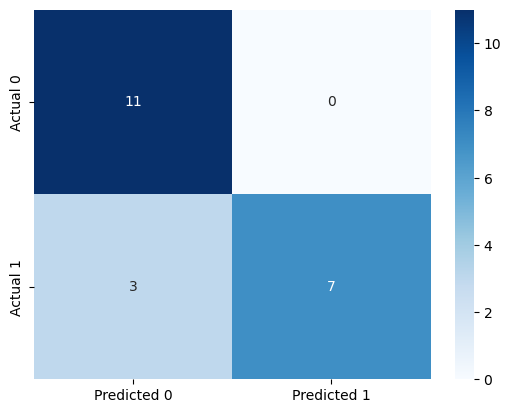

In [47]:
sns.heatmap(confusion_matrix(y_test,ypreds_resnet50),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for ResNet152

In [48]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_resnet152)}")
print(f"Precision: {precision_score(y_test,ypreds_resnet152)}")
print(f"Recall: {recall_score(y_test,ypreds_resnet152)}")
print(f"F1 Score: {f1_score(y_test,ypreds_resnet152)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_resnet152)}")

Accuracy: 0.9523809523809523
Precision: 1.0
Recall: 0.9
F1 Score: 0.9473684210526315
ROC Score: 0.95


<Axes: >

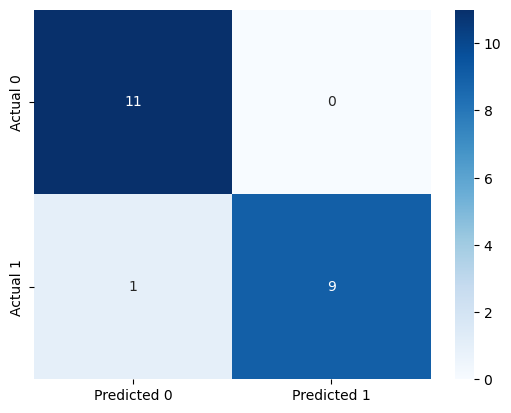

In [49]:
sns.heatmap(confusion_matrix(y_test,ypreds_resnet152),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for InceptionNet

In [50]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_inception)}")
print(f"Precision: {precision_score(y_test,ypreds_inception)}")
print(f"Recall: {recall_score(y_test,ypreds_inception)}")
print(f"F1 Score: {f1_score(y_test,ypreds_inception)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_inception)}")

Accuracy: 0.7619047619047619
Precision: 0.7272727272727273
Recall: 0.8
F1 Score: 0.7619047619047619
ROC Score: 0.7636363636363637


<Axes: >

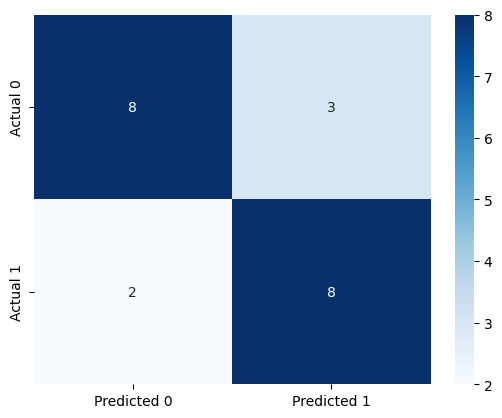

In [51]:
sns.heatmap(confusion_matrix(y_test,ypreds_inception),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for VGG19

In [52]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_vgg19)}")
print(f"Precision: {precision_score(y_test,ypreds_vgg19)}")
print(f"Recall: {recall_score(y_test,ypreds_vgg19)}")
print(f"F1 Score: {f1_score(y_test,ypreds_vgg19)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_vgg19)}")

Accuracy: 0.8095238095238095
Precision: 0.875
Recall: 0.7
F1 Score: 0.7777777777777778
ROC Score: 0.8045454545454546


<Axes: >

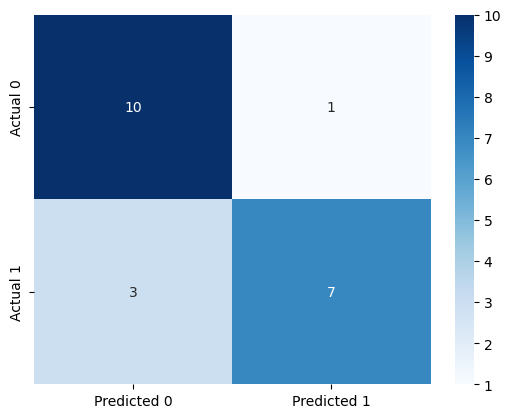

In [53]:
sns.heatmap(confusion_matrix(y_test,ypreds_vgg19),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])

# Metrics for MobileNet V3

In [54]:
print(f"Accuracy: {accuracy_score(y_test,ypreds_mobilenet)}")
print(f"Precision: {precision_score(y_test,ypreds_mobilenet)}")
print(f"Recall: {recall_score(y_test,ypreds_mobilenet)}")
print(f"F1 Score: {f1_score(y_test,ypreds_mobilenet)}")
print(f"ROC Score: {roc_auc_score(y_test,ypreds_mobilenet)}")

Accuracy: 0.7619047619047619
Precision: 0.7777777777777778
Recall: 0.7
F1 Score: 0.7368421052631579
ROC Score: 0.759090909090909


<Axes: >

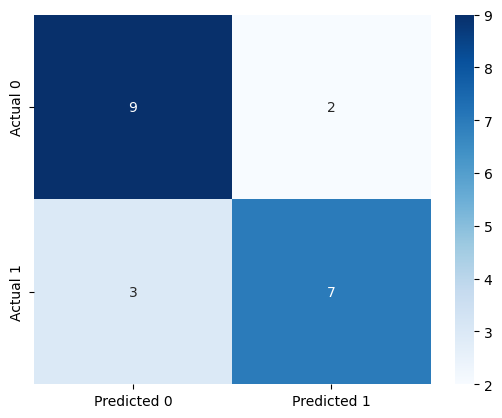

In [55]:
sns.heatmap(confusion_matrix(y_test,ypreds_mobilenet),annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])